<center><img src="../meta/TRAIDENT.png" width="210"/></center>

# Preprocessing training-datacubes
---

In [1]:
### 3rd party packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr
from scipy.stats import gaussian_kde
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

### User packages
from training_utils.preprocessing import *

## Open the zarr dataset 

In [27]:
zarrpath = "/scratch3/users/jdawson/parrot-cube-1-dirty-bad-chunking.zarr"
xrdata = xr.open_dataset(zarrpath, engine='zarr')
cube = xrdata['hdu']

## Get a chunk from the zarr dataset ready for fake signal injection

In [28]:
# del chunk
chunk = getChunkIndexed(cube, 1348, 1348, blockSize=64)
print(f"Size of chunk: {chunk.shape}")

Size of chunk: (4608, 128, 128)


In [29]:
# Inject a fake peak and fake periodic signals into the chunk
chunk = inject_fake_signal(chunk, 30, 100, 3000, 7, 2)
# chunk = inject_fake_signal(chunk, 30, 100, 1000, 3, 20)
# chunk = inject_fake_signal(chunk, 30, 100, 3000, 3, 20)
# chunk = inject_fake_signal(chunk, 30, 100, 4000, 7, 20)
# chunk = inject_fake_periodic_signal(chunk, 40, 40, 0, 0.5, 100)
# chunk = inject_fake_periodic_signal(chunk, 20, 100, 0, 0.5, 300)
chunk = inject_periodic_gaussian_signal(chunk, 40, 40, np.pi, 5, 120, width=16)
chunk = inject_periodic_gaussian_signal(chunk, 20, 100, np.pi, 5, 120, width=8)

In [47]:
from scipy.signal import correlate

In [48]:
auto = correlate(chunk[:, 40, 40], chunk[:, 40, 40], mode='full')
auto = auto[auto.size//2:]  # Keep only positive lags
fft_auto = np.abs(np.fft.rfft(auto))**2

In [53]:
fft_auto.shape

(2305,)

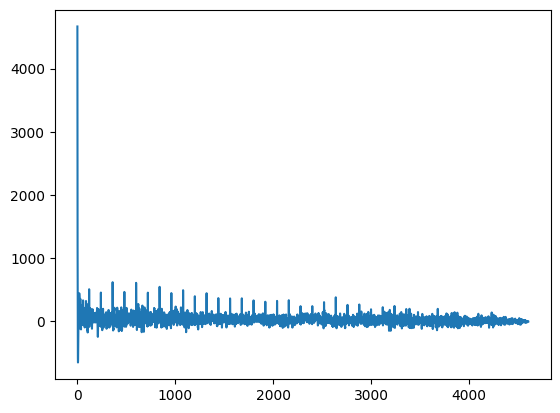

In [57]:
plt.figure()
plt.plot(autocorr_cube[:,40,40])

In [30]:
# THIS MUST COME AFTER SIGNAL INJECTION!!
chunk /= chunk.std(0)

In [31]:
N = chunk.shape[0]  # Number of sample points
T = 1  # Sampling interval (1/sample rate)
t = np.linspace(0, (N-1)*T, N, endpoint=False)
xf = np.fft.fftfreq(N, T) 
ps_cube = np.fft.rfft(chunk, n=N, axis=0)
power_spectrum = np.abs(ps_cube)**2
# power_spectrum /= np.std(power_spectrum, axis=0)[None,:,:]
power_spectrum /= np.std(power_spectrum)
max_ps = power_spectrum.max(0)
argmax_ps = power_spectrum.argmax(0)/(1/xf[1])

In [56]:
def fft_autocorr_chunk(chunk):
    # Zero-pad to 2*T for full autocorr
    T, H, W = chunk.shape
    n = 2 * T

    # FFT along time axis
    fft_chunk = np.fft.fft(chunk, n=n, axis=0)
    
    # Power spectrum
    power = np.abs(fft_chunk)**2

    # IFFT to get autocorrelation
    ac_full = np.fft.ifft(power, axis=0).real

    # Normalize and return only positive lags
    return ac_full[:T]
    
autocorr_cube = fft_autocorr_chunk(chunk)

In [32]:
ps_time = 1/xf[1:N//2]

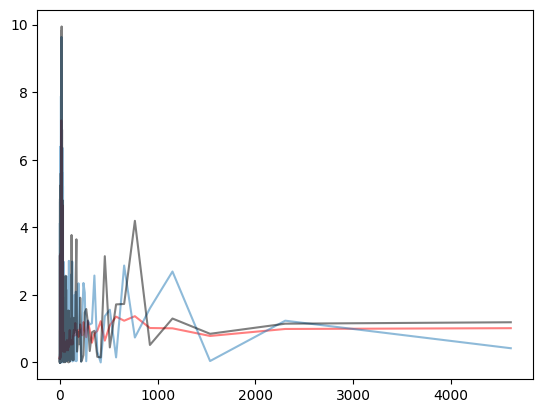

In [35]:
plt.close('all')
plt.figure()
plt.plot(ps_time, np.median(power_spectrum[1:N//2],(1,2)), 'r-', alpha=0.5)
plt.plot(ps_time, power_spectrum[1:N//2,20,100], alpha=0.5)
plt.plot(ps_time, power_spectrum[1:N//2,40,40], 'k-', alpha=0.5)
# plt.plot(ps_time, before, 'k-', alpha=0.5)
# plt.plot(chunk[:,30,100], alpha=0.5)
# plt.plot(chunk[:,40,40], alpha=0.5)
# plt.plot(chunk[:,87,31], alpha=0.5)

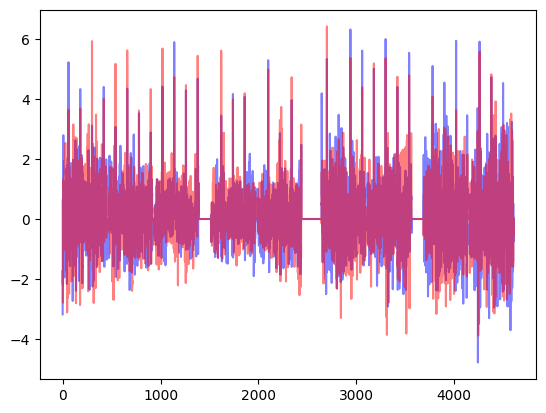

In [46]:
plt.close('all')
plt.figure()
plt.plot(chunk[:,20,100],'b-', alpha=0.5)
plt.plot(chunk[:,40,40], 'r-', alpha=0.5)
# plt.plot(chunk[:,30,100], 'k-', alpha=0.5)
# plt.plot(chunk[:,87,31], alpha=0.5)

In [15]:
ps_time[power_spectrum[1:N//2,20,100].argmax()]

3.2

In [259]:
flux_grad_raw = np.diff(chunk, axis=0)
flux_grad_raw[flux_grad_raw == 0] = np.nan

# Parameters
pad = 15
time_steps, height, width = flux_grad_raw.shape
base_idx = np.arange(-pad, pad, 1)

# Function to compute std for a given time slice
def compute_std(t):
    idx = np.clip(base_idx + t, 0, time_steps - 1)
    return np.nanstd(flux_grad_raw[idx], axis=0)

# Use multiprocessing to parallelize computation
with mp.Pool(processes=mp.cpu_count()) as pool:
    results = list(tqdm(pool.imap(compute_std, range(time_steps)), total=time_steps))

# Convert results list to a NumPy array
flux_grad_local = np.array(results)

# Normalize
flux_grad = np.divide(flux_grad_raw, flux_grad_local, where=~np.isnan(flux_grad_local))
flux_grad_max = np.nanmax(flux_grad, 0) 
### THIS NOW NEEDS NORMALISING BEFORE USE!!!

del flux_grad_raw, flux_grad_local, results, pool
import gc; gc.collect()  # Force garbage collection


00%|██████████| 4607/4607 [00:09<00:00, 465.65it/s]

6716

In [37]:
flux_raw = chunk.copy()
flux_raw[chunk == 0] = np.nan

# Parameters
pad = 15
time_steps, height, width = flux_raw.shape
base_idx = np.arange(-pad, pad, 1)

# Function to compute std for a given time slice
def compute_std_flux(t):
    idx = np.clip(base_idx + t, 0, time_steps - 1)
    return np.nanstd(flux_raw[idx], axis=0)

# Use multiprocessing to parallelize computation
with mp.Pool(processes=mp.cpu_count()) as pool_flux:
    results_flux = list(tqdm(pool_flux.imap(compute_std_flux, range(time_steps)), total=time_steps))

# Convert results list to a NumPy array
flux_local = np.array(results_flux)

# Normalize
flux_normed = np.divide(flux_raw, flux_local, where=~np.isnan(flux_local)) # raw flux / std(local flux window)
flux_max_local_normed = np.nanmax(flux_normed, 0) 
flux_argmax_local_normed = np.nanargmax(flux_normed, axis=0) 
# raw flux at local argmax / std of full time series
flux_max_normed = flux_raw[flux_argmax_local_normed, np.arange(chunk.shape[1])[:,None], np.arange(chunk.shape[2])] / np.nanstd(flux_raw,0)
flux_argmax_local_normed = flux_argmax_local_normed/chunk.shape[0]

### THIS NOW NEEDS NORMALISING BEFORE USE!!!

del flux_raw, flux_local, results_flux, pool_flux
import gc; gc.collect()


00%|██████████| 4608/4608 [00:07<00:00, 608.59it/s]

62

In [42]:
max_ps[40,40]

32.686239875104796

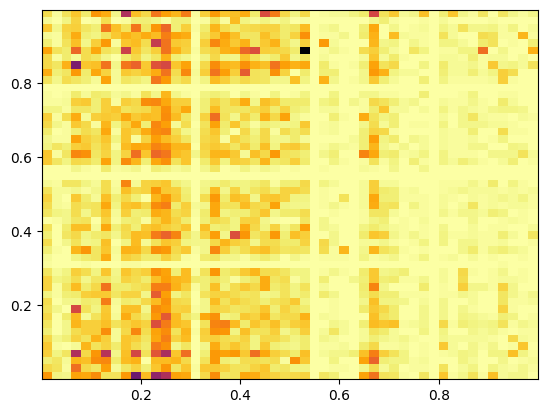

In [92]:
plt.close('all')
fig = plt.hist2d(flux_argmax.flatten(), flux_grad_argmax.flatten(), bins=50, cmap='inferno_r')

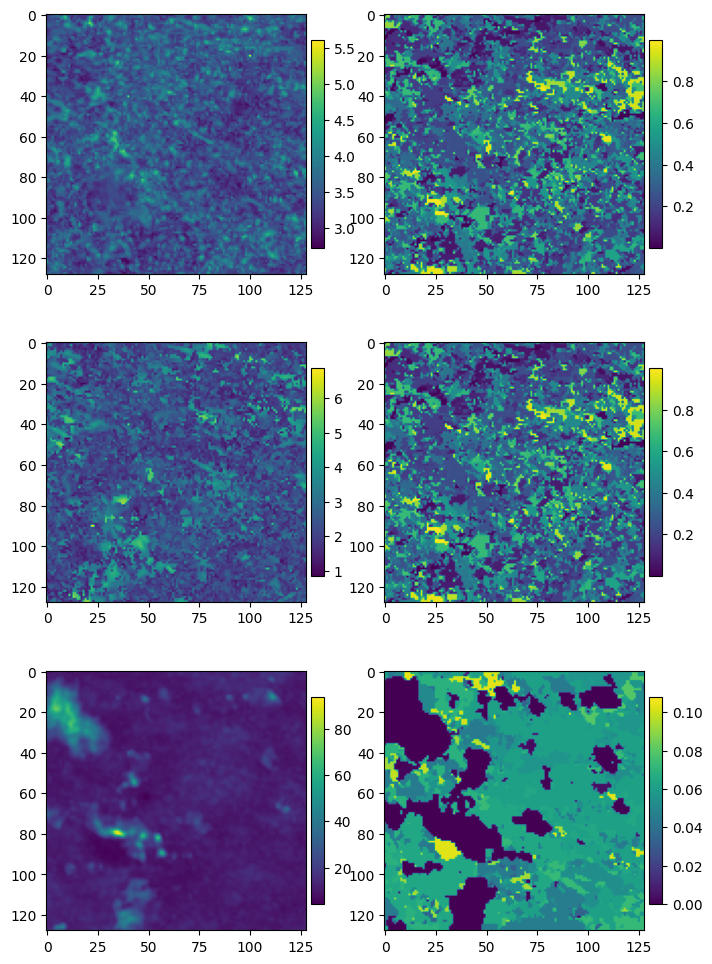

In [39]:
plt.close('all')
# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(7, 10))

# Data list
data = [flux_max_local_normed, flux_argmax_local_normed, flux_max_normed, flux_argmax_local_normed,  max_ps, argmax_ps]

# Loop over axes and add colorbars
for ax, dat in zip(axs.flat, data):
    im = ax.imshow(dat)
    
    # Create a tight colorbar
    cbar_ax = ax.inset_axes([1.02, 0.1, 0.05, 0.8])  # [x, y, width, height] (relative to ax)
    fig.colorbar(im, cax=cbar_ax)

plt.tight_layout()
plt.show()

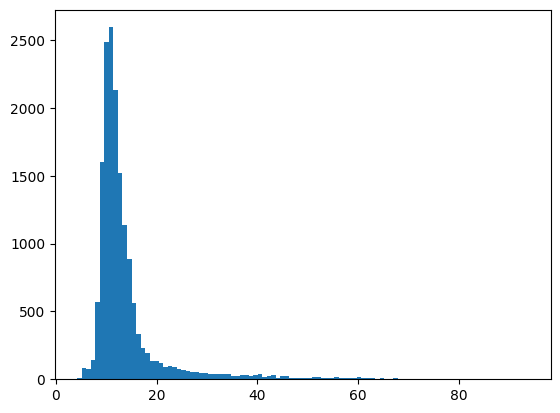

In [40]:
plt.figure()
histogram = plt.hist(max_ps.reshape(-1), bins=100)

In [164]:
flux_grad_argmax[30,100], flux_argmax[30,100], argmax_ps[30,100]

(0.7055121527777778, 0.4338107638888889, 0.0)

In [30]:
np.unravel_index(max_ps.argmax(), max_ps.shape)

(40, 40)

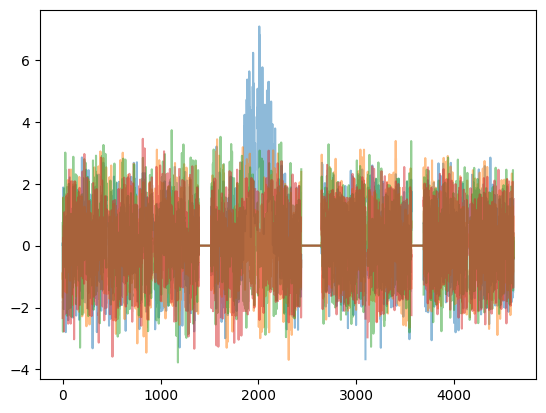

In [13]:
plt.figure()
plt.plot(flux_grad[:,30,100], alpha=0.5)
plt.plot(flux_grad[:,20,100], alpha=0.5)
plt.plot(flux_grad[:,40,40], alpha=0.5)
plt.plot(flux_grad[:,100,100], alpha=0.5)

In [128]:
np.percentile(flux_grad_max.flatten(), 50)

3.456469774246216

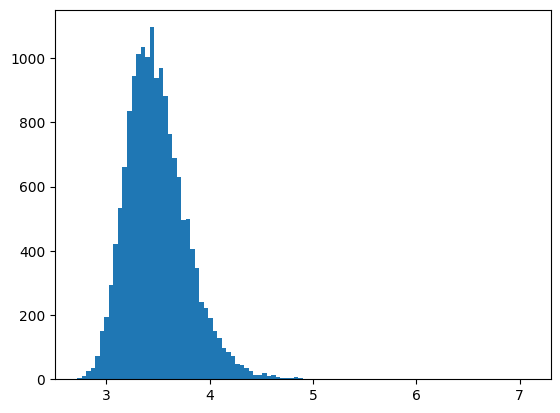

In [129]:
plt.close('all')
f = plt.hist(flux_grad_max.flatten(), bins = 100)

In [87]:
np.unravel_index(flux_grad_max.argmax(), flux_grad_max.shape)

(30, 100)

In [53]:
N = chunk.shape[0]  # Number of sample points
T = 1  # Sampling interval (1/sample rate)
t = np.linspace(0, (N-1)*T, N, endpoint=False)
xf = np.fft.fftfreq(N, T) 
ps_cube = np.fft.rfft(chunk, n=N, axis=0)
power_spectrum = np.abs(ps_cube)**2

In [54]:
power_spectrum -= np.median(power_spectrum, axis=0)[None,:,:]
# power_spectrum = power_spectrum[10:N//2,:,:]
# xf = xf[10:N//2]

In [49]:
idx_peak = np.argmax(power_spectrum[10:N//2,:,:], axis=0) + 10  # Get index of peak for each (x, y)
f_peak = xf[idx_peak] 

In [180]:
# Extract amplitude and phase for each (x, y)
A = (2 * np.abs(ps_cube[idx_peak, np.arange(ps_cube.shape[1])[:, None], np.arange(ps_cube.shape[2])])) / N
# Special case: Do not double DC component
A[idx_peak == 0] /= 2  
phi = np.angle(ps_cube[idx_peak, np.arange(ps_cube.shape[1])[:, None], np.arange(ps_cube.shape[2])])

In [181]:
# Reconstruct the sine wave
reconstructed_wave = A * np.cos(2 * np.pi * f_peak * t[:, None, None] + phi)

In [107]:
N = 1
nth_largest = np.partition(power_spectrum, -N, axis=0)[-N]

In [55]:
max_ps = power_spectrum.max(0)

In [56]:
max_ps

array([[0.00540845, 0.0053365 , 0.0053139 , ..., 0.00559503, 0.00601369,
        0.00608587],
       [0.00563391, 0.00549042, 0.00581888, ..., 0.00530142, 0.00612326,
        0.00620959],
       [0.00643652, 0.00631072, 0.00638849, ..., 0.00543544, 0.00601645,
        0.00634   ],
       ...,
       [0.00752335, 0.0071629 , 0.00697393, ..., 0.00553961, 0.00586574,
        0.00618878],
       [0.00734159, 0.00728292, 0.00705534, ..., 0.00589376, 0.00644845,
        0.00671471],
       [0.00742018, 0.00765682, 0.00871855, ..., 0.00615967, 0.00673966,
        0.00690688]])

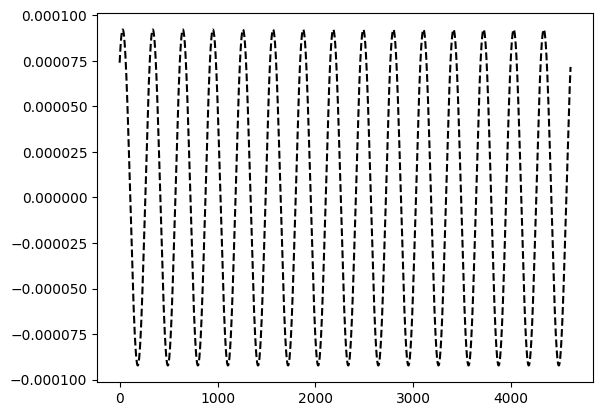

In [182]:
plt.figure()
plt.plot(reconstructed_wave[:,20,100], 'k--')

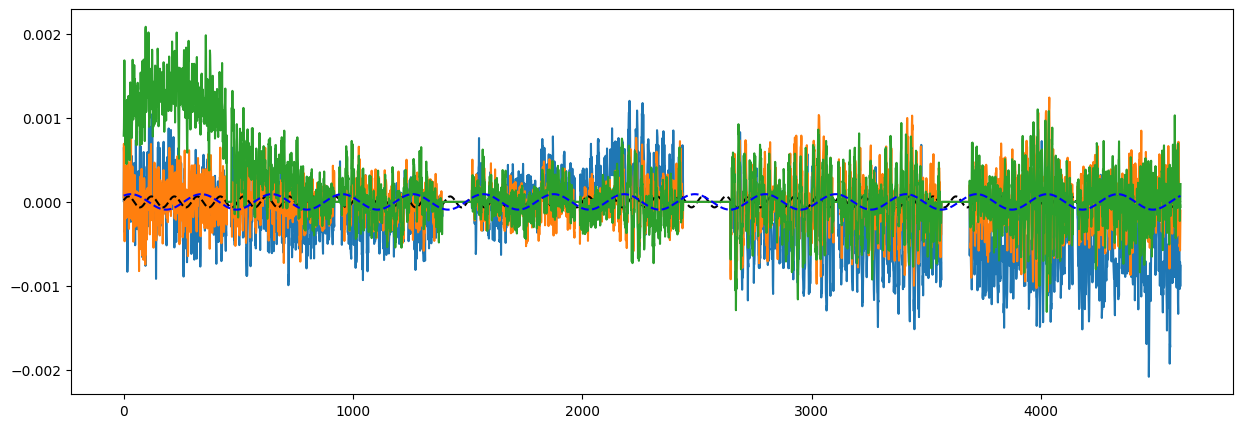

In [186]:
plt.close('all')
plt.figure(figsize=(15,5))
plt.plot(chunk[:,127,32])
plt.plot(chunk[:,40,40])
plt.plot(reconstructed_wave[:,40,40], 'k--')
plt.plot(chunk[:,20,100])
plt.plot(reconstructed_wave[:,20,100], 'b--')

In [21]:
np.argmin(np.abs(480 - 1/xf[:N//2]))

/tmp/ipykernel_10031/1459542215.py:1: RuntimeWarning: divide by zero encountered in divide
  np.argmin(np.abs(480 - 1/xf[:N//2]))


10

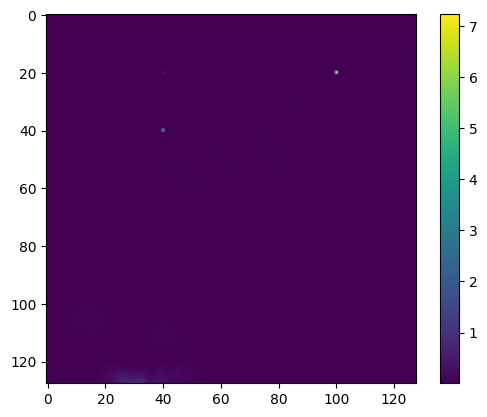

In [172]:
plt.figure()
plt.imshow(max_ps)
plt.colorbar()

/tmp/ipykernel_10031/2469758127.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/xf, power_spectrum[:,127,32])


ValueError: x and y must have same first dimension, but have shapes (4608,) and (2305,)

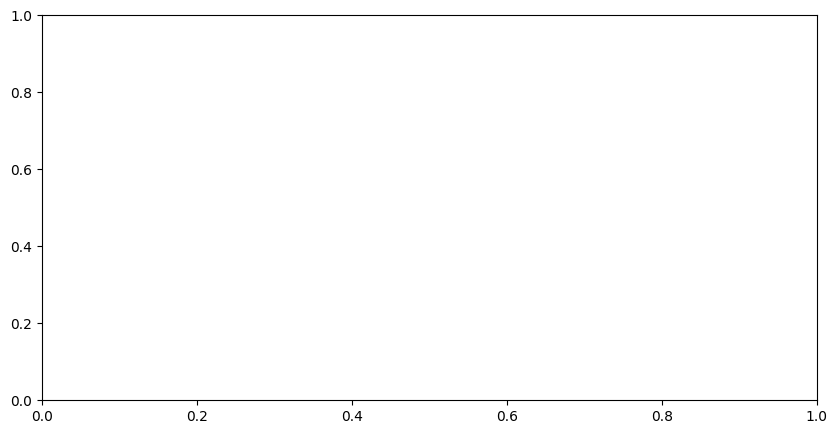

In [170]:
plt.close('all')
plt.figure(figsize=(10,5))
# plt.plot(1/xf[:N//2], power_spectrum[:-1,127,32])
# plt.plot(1/xf[:N//2], power_spectrum[:-1,20,100])
# plt.plot(1/xf[:N//2], power_spectrum[:-1,20,40])
# plt.plot(1/xf[:N//2], power_spectrum[:-1,40,40])
# plt.plot(1/xf, power_spectrum[:,127,32])
plt.plot(1/xf, power_spectrum[:,20,100])
# plt.plot(1/xf, power_spectrum[:,20,40])
plt.plot(1/xf, power_spectrum[:,40,40])

In [13]:
plt.close('all')
plt.figure(figsize=(10,5))

for i in range(5):
    xy = int(np.random.uniform(10,power_spectrum.shape[1]-10,1))
    minicube = power_spectrum[:,xy-9:xy+9,xy-9:xy+9][:N//2]
    targetpx = minicube[:,4,4]
    diff_ps = np.abs(np.mean(minicube - targetpx[:,None,None], (1,2)) / minicube.max())
    plt.plot(1/xf[:N//2], diff_ps, label=str(xy))
plt.legend()

/tmp/ipykernel_5822/1991782375.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xy = int(np.random.uniform(10,power_spectrum.shape[1]-10,1))


ValueError: zero-size array to reduction operation maximum which has no identity

<Figure size 1000x500 with 0 Axes>

## Define a fake signal injection

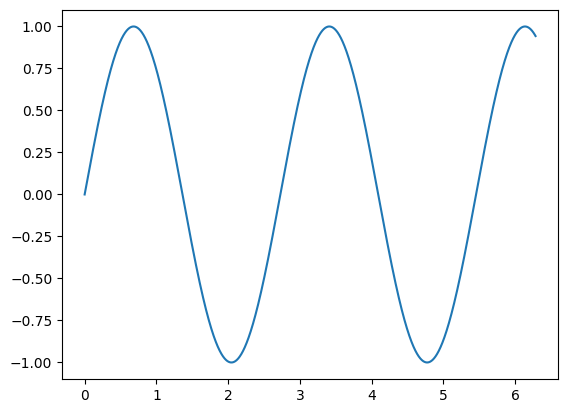

In [180]:
x = np.linspace(0,2*np.pi,cube.shape[0])
freq = cube.shape[0] / 2000
phase = 0
signal = np.sin(phase + x*freq)
plt.close('all')
plt.figure()
plt.plot(x, signal)

In [95]:
pixel = inject_fake_signal(chunk, 20, 100, 200, 5, 250)
pixel = inject_fake_periodic_signal(chunk, 20, 40, 0, 5, 250)

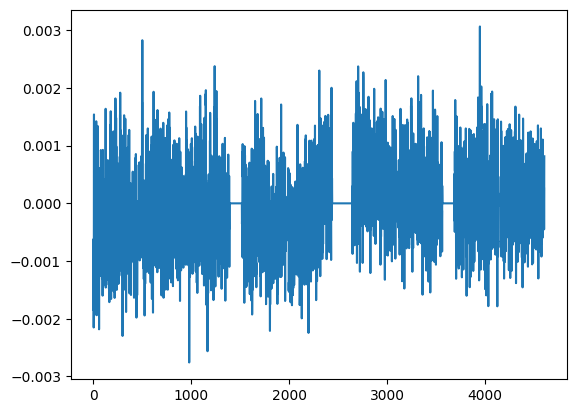

In [96]:
plt.close('all')
plt.figure()
plt.plot(pixel[:,150,76])

# Define a neighbourhood input vector calculator (numpy)

In [286]:
def get_neighbourhood(cube, row, column, channel, Nxy, Nt):
    assert Nxy % 2 != 0, f"Spatial selection Nxy: {Nxy} must be an odd number"
    assert Nt % 2 != 0, f"Temporal selection Nt: {Nt} must be an odd number"
    # Ensure the position is within bounds
    chan_start = min(max(0, channel - Nt), cube.shape[0] - Nt)
    chan_end = min(cube.shape[0], chan_start + Nt)
    row_start = min(max(0, row - Nxy), cube.shape[1] - Nxy)
    row_end = min(cube.shape[1], row_start + Nxy)
    col_start = min(max(0, column - Nxy), cube.shape[2] - Nxy)
    col_end = min(cube.shape[2], col_start + Nxy)
    return cube[chan_start:chan_end, row_start:row_end, col_start:col_end] # Select neighbourhood

def rescale_neighbourhood(neighbourhood):
    # Rescale to avoid moving into high incorrect flux-offset regions
    return neighbourhood - np.median(neighbourhood)

def flux_scale(neighbourhood):
    # Calculate the sum of the flux in the region
    return neighbourhood.sum()

def gradient(neighbourhood, xy, t):
    # Calculate the greedy and smooth gradients in each direction from the center of the neighbourhood
    grad_t = np.gradient(neighbourhood, axis=0)  # Time gradient
    grad_x = np.gradient(neighbourhood, axis=1)  # X gradient
    grad_y = np.gradient(neighbourhood, axis=2)  # Y gradient

    raw_gradient = np.abs([grad_t, grad_x, grad_y])
    greedy_gradient = raw_gradient.max((1,2,3)) # Greedy = looking at the maximum gradient in a direction
    smooth_gradient = np.abs(raw_gradient).mean((1,2,3)) # Smooth = looking at the average gradient in a direction
    return greedy_gradient, smooth_gradient

def anomaly_distance(cube, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt):
    # Calculate the position error and bounding box error for the anomaly proximity reward
    distance = np.sqrt((row-a_x)**2 + (column-a_y)**2 + (channel-a_t)**2)
    distance_weighted = 1 - (distance / (cube.shape[0] * cube.shape[1] * cube.shape[2])) # Penalises being a distance approaching the size of the cube away from the target
    bounding_xy = 1 - np.sqrt((Nxy - a_Nxy)**2) / cube.shape[1] # Penalises having a bounding box the size of the cube
    bounding_t = 1 - np.sqrt((Nt-a_Nt)**2) / cube.shape[0] # Penalises having a bounding box the size of the cube
    return distance_weighted, bounding_xy, bounding_t

In [287]:
row, column, channel, Nxy, Nt = 64, 64, 4201, 3, 3
a_x, a_y, a_t, a_Nxy, a_Nt = 64,64,4201,3,3
neighbourhood = get_neighbourhood(cube=chunk, row=row, column=column, channel=channel, Nxy=Nxy, Nt=Nt)
neighbourhood = rescale_neighbourhood(neighbourhood)
flux = flux_scale(neighbourhood)
greedy_grad, smooth_grad = gradient(neighbourhood, 50, 150)
distance_weighted, bounding_xy, bounding_t = anomaly_distance(chunk, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt)
input_vector = [flux, greedy_grad[0], greedy_grad[1], greedy_grad[2], smooth_grad[0], smooth_grad[1], smooth_grad[2]]

# Define a neighbourhood input vector calculator (torch)

In [6]:
def get_neighbourhood(cube, row, column, channel, Nxy, Nt):
    # assert Nxy % 2 != 0, f"Spatial selection Nxy: {Nxy} must be an odd number"
    # assert Nt % 2 != 0, f"Temporal selection Nt: {Nt} must be an odd number"

    Nt = torch.round(Nt*64)
    Nxy = torch.round(Nxy*64)
    
    # Ensure the position is within bounds
    chan_start = min(max(0, channel - Nt), cube.shape[0] - Nt)
    chan_end = min(cube.shape[0], chan_start + Nt)
    row_start = min(max(0, row - Nxy), cube.shape[1] - Nxy)
    row_end = min(cube.shape[1], row_start + Nxy)
    col_start = min(max(0, column - Nxy), cube.shape[2] - Nxy)
    col_end = min(cube.shape[2], col_start + Nxy)
    
    return cube[chan_start:chan_end, row_start:row_end, col_start:col_end]  # Select neighbourhood

def rescale_neighbourhood(neighbourhood):
    # Rescale to avoid moving into high incorrect flux-offset regions
    return neighbourhood - torch.median(neighbourhood)

def flux_scale(neighbourhood):
    # Calculate the sum of the flux in the region
    return np.abs(neighbourhood.sum())

def gradient(neighbourhood):
    # Compute gradients manually using torch.diff (PyTorch's equivalent to np.gradient)
    grad_t = torch.diff(neighbourhood, dim=0, prepend=neighbourhood[0:1])  # Temporal gradient, pad at the start
    grad_x = torch.diff(neighbourhood, dim=1, prepend=neighbourhood[:, 0:1, :])  # X gradient, pad at the start
    grad_y = torch.diff(neighbourhood, dim=2, prepend=neighbourhood[:, :, 0:1])  # Y gradient, pad at the start
    # Convert gradients to absolute values
    raw_gradient = torch.abs(torch.stack([grad_t, grad_x, grad_y]))
    # Calculate greedy gradient (maximum gradient in a direction)
    greedy_gradient = raw_gradient.max()
    # Calculate smooth gradient (mean gradient in a direction)
    smooth_gradient = raw_gradient.mean()
    return greedy_gradient, smooth_gradient

# def anomaly_distance(cube, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt):
#     # Calculate the position error and bounding box error for the anomaly proximity reward
#     # distance_xy = 1 - (torch.sqrt((row-a_x)**2 + (column-a_y)**2) / torch.sqrt(torch.tensor(cube.shape[1]**2 + cube.shape[2]**2)))
#     distance_x = 2*(1 - (torch.sqrt((row-a_x)**2) / cube.shape[1])) -1  # row distance only
#     distance_y = 2*(1 - (torch.sqrt((column-a_y)**2) / cube.shape[2])) -1  # col distance only
#     # distance_t = 1 - torch.sqrt((channel-a_t)**2) / cube.shape[0]
#     distance_t = 2*(1 - (torch.sqrt((channel-a_t)**2) / cube.shape[0])) -1
#     bounding_xy = 1 - (torch.sqrt((Nxy - a_Nxy)**2) / cube.shape[1])
#     bounding_t = 1 - (torch.sqrt((Nt-a_Nt)**2) / cube.shape[0])
#     return distance_x, distance_y, distance_t#, bounding_xy, bounding_t

def anomaly_distance(cube, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt):
    distance_x = torch.abs(row*64-a_x)/64  # row distance 
    distance_y = torch.abs(column*64-a_y)/64  # col distance 
    distance_t = torch.abs(channel*4608-a_t)/4608 # time distance 
    distance_bb_xy = torch.abs(Nxy*64-a_Nxy)/64  # row/column bounding box distance 
    distance_bb_t = torch.abs(Nt*4608-a_Nt)/4608 # time bounding box distance 
    return distance_x, distance_y, distance_t, distance_bb_xy, distance_bb_t 

def local_scores(cube, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt):
    # Calculate the position error and bounding box error for the anomaly proximity reward
    distance_x = 2*(1 - (torch.sqrt((row-a_x)**2) / cube.shape[1])) -1  # row distance only
    distance_y = 2*(1 - (torch.sqrt((column-a_y)**2) / cube.shape[2])) -1  # col distance only
    # distance_t = 1 - torch.sqrt((channel-a_t)**2) / cube.shape[0]
    distance_t = 2*(1 - (torch.sqrt((channel-a_t)**2) / cube.shape[0])) -1
    # bounding_xy = 1 - (torch.sqrt((Nxy - a_Nxy)**2) / cube.shape[1])
    # bounding_t = 1 - (torch.sqrt((Nt-a_Nt)**2) / cube.shape[0])
    return distance_x, distance_x, distance_x

In [8]:
torch_chunk = torch.tensor(chunk)

In [9]:
torch_chunk.shape

torch.Size([4608, 64, 64])

In [30]:
a_x, a_y, a_t, a_Nxy, a_Nt = torch.tensor(40), torch.tensor(8), torch.tensor(1000), torch.tensor(3), torch.tensor(20)
row, column, channel, Nxy, Nt = torch.arange(torch_chunk.shape[1]), torch.arange(torch_chunk.shape[2]), torch.arange(torch_chunk.shape[0]), torch.tensor(7), torch.tensor(31)
local_scores(torch_chunk, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt)

tensor([ 0.5660,  0.5664,  0.5668,  ..., -0.5647, -0.5651, -0.5655])

# Define a function for injecting signals into torch tensor cubes

In [154]:
def normal_sample(xarray, channel, amplitude, duration):
    """Creates a normal distribution of points with no scatter using PyTorch."""
    a = 1 / (duration * torch.sqrt(torch.tensor(2 * torch.pi)))
    b = torch.exp(-0.5 * (((xarray - channel) / duration) ** 2))
    norm = a * b
    norm = amplitude * norm / norm.max()
    return norm

def inject_fake_signal(cube, row, column, channel, amplitude, duration):
    """Injects a fake normal signal with amplitude scaled by pixel RMS at a given position."""
    xarray = torch.arange(cube.shape[0], device=cube.device)  # Create an index array
    pixel = cube[:, row, column]  # Get the pixel time series
    rms = torch.sqrt((pixel * pixel).sum() / cube.shape[0])  # Compute RMS
    signal = normal_sample(xarray, channel, amplitude * rms, duration)  # Generate signal
    signal = torch.where(pixel != 0, signal, torch.tensor(0.0, device=cube.device))  # Mask zero pixels
    cube[:, row, column] += signal  # Inject signal
    return cube

# Create a PyTorch policy network for RL with a single injected source

In [38]:
class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.ReLU = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)  # Outputs probabilities for movement
    
    def forward(self, x):
        x = self.ReLU(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

# Initialize policy network
input_size = 5  # Matches input_vector dimensions
hidden_size = 6 # Can be adjusted
output_size = 10  # Moves: +row, -row, +col, -col, +channel, -channel
policy = PolicyNet(input_size, hidden_size, output_size)
optimizer = optim.Adam(policy.parameters(), lr=0.1)
criterion = nn.MSELoss()  # Placeholder loss (we will use REINFORCE-like updates)

# Define action mapping
actions = [
    torch.tensor([1, 0, 0, 0, 0]), torch.tensor([-1, 0, 0, 0, 0]),  # Row movement
    torch.tensor([0, 1, 0, 0, 0]), torch.tensor([0, -1, 0, 0, 0]),  # Column movement
    torch.tensor([0, 0, 11, 0, 0]), torch.tensor([0, 0, -11, 0, 0]),  # Channel movement
    torch.tensor([0, 0, 0, 1, 0]), torch.tensor([0, 0, 0, -1, 0]),  # Row / Column bounding box size adjustment
    torch.tensor([0, 0, 0, 0, 1]), torch.tensor([0, 0, 0, 0, -1])  # Channel bounding box size adjustment
]

# Training loop
num_steps = 300000
positions = [] 

row, column, channel, Nxy, Nt = torch.tensor(0.1), torch.tensor(0.1), torch.tensor(0.75), torch.tensor(0.7), torch.tensor(0.01)
a_x, a_y, a_t, a_Nxy, a_Nt = torch.tensor(40), torch.tensor(40), torch.tensor(1000), torch.tensor(5), torch.tensor(5)

# Scaling limits for neighborhood size
Nxy_min, Nxy_max = 3, 3
Nt_min, Nt_max = 21, 21

def get_input_vector():
    # tneighbourhood = get_neighbourhood(cube=torch_chunk, row=row, column=column, channel=channel, Nxy=Nxy, Nt=Nt)
    # tneighbourhood = rescale_neighbourhood(tneighbourhood)
    distance_x, distance_y, distance_t, distance_bb_xy, distance_bb_t = anomaly_distance(torch_chunk, row, column, channel, Nxy, Nt, a_x, a_y, a_t, a_Nxy, a_Nt)
    return torch.stack([distance_x, distance_y, distance_t, distance_bb_xy, distance_bb_t])

running_loss, running_reward, running_action_probs, running_inputs  = [],[],[],[]

for step in range(num_steps):
    positions.append((row.item()*64, column.item()*64, channel.item()*4608, Nxy.item()*64, Nt.item()*4608))
    
    input_vector = get_input_vector()
    running_inputs.append(input_vector)
    action_probs = policy(input_vector.float())
    running_action_probs.append(action_probs)
    action_index = torch.multinomial(action_probs, 1)
    move = actions[action_index]

    # Apply movement
    row = torch.clamp(row*64 + move[0], Nxy_max, torch_chunk.shape[1] - Nxy_max)/64
    column = torch.clamp(column*64 + move[1], Nxy_max, torch_chunk.shape[2] - Nxy_max)/64
    channel = torch.clamp(channel*4608 + move[2], Nt_max, torch_chunk.shape[0] - Nt_max)/4608
    Nxy = torch.clamp(Nxy*64 + move[3], 1, torch_chunk.shape[1]) / 64
    Nt = torch.clamp(Nt*4608 + move[4], 1, torch_chunk.shape[0]) / 4608

    reward = abs(row*64 - a_x)/64 + abs(column*64 - a_y)/64 + abs(channel*4608 - a_t)/4608 +\
        abs(Nxy*64 - a_Nxy)/64 + abs(Nt*4608 - a_Nt)/4608# * torch_chunk.shape[1]/torch_chunk.shape[0])
    
    running_reward.append(reward)
   
    loss = reward * action_probs[action_index]
    running_loss.append(loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

all_loss = torch.tensor(running_loss).detach().numpy()
all_rewards = torch.stack(running_reward).detach().numpy()
all_action_probs = torch.stack(running_action_probs).detach().numpy()
all_inputs = torch.stack(running_inputs).detach().numpy()

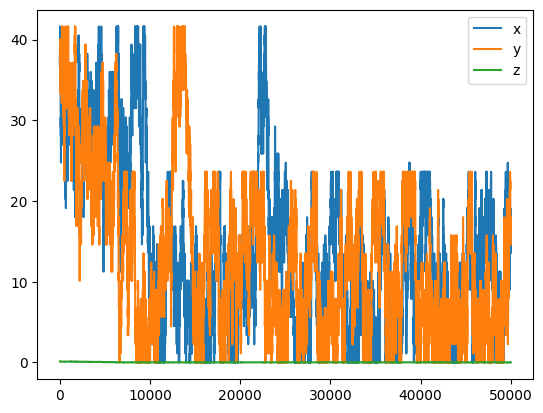

In [508]:
plt.close('all')
plt.figure()
plt.plot(all_inputs[:,0], label = 'x')
plt.plot(all_inputs[:,1], label = 'y')
plt.plot(all_inputs[:,2], label = 'z')
plt.legend()

/idia/users/jdawson/torchenv/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/idia/users/jdawson/torchenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


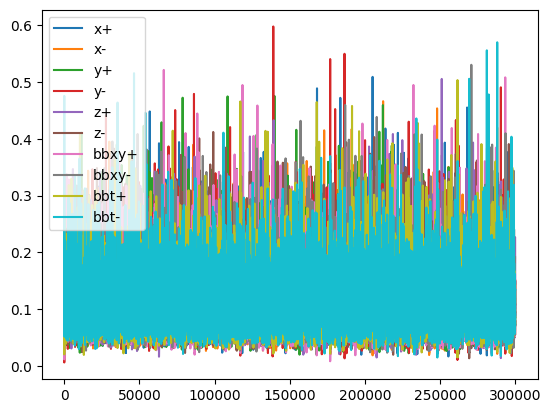

In [39]:
plt.close('all')
plt.figure()
plt.plot(all_action_probs[:,0], label = 'x+')
plt.plot(all_action_probs[:,1], label = 'x-')
plt.plot(all_action_probs[:,2], label = 'y+')
plt.plot(all_action_probs[:,3], label = 'y-')
plt.plot(all_action_probs[:,4], label = 'z+')
plt.plot(all_action_probs[:,5], label = 'z-')
plt.plot(all_action_probs[:,6], label = 'bbxy+')
plt.plot(all_action_probs[:,7], label = 'bbxy-')
plt.plot(all_action_probs[:,8], label = 'bbt+')
plt.plot(all_action_probs[:,9], label = 'bbt-')
plt.legend()

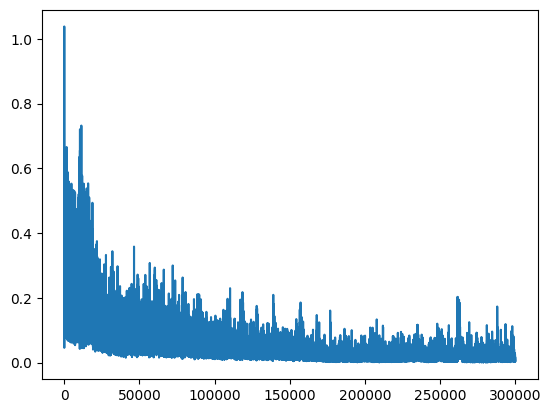

In [40]:
plt.figure()
plt.plot(all_loss)

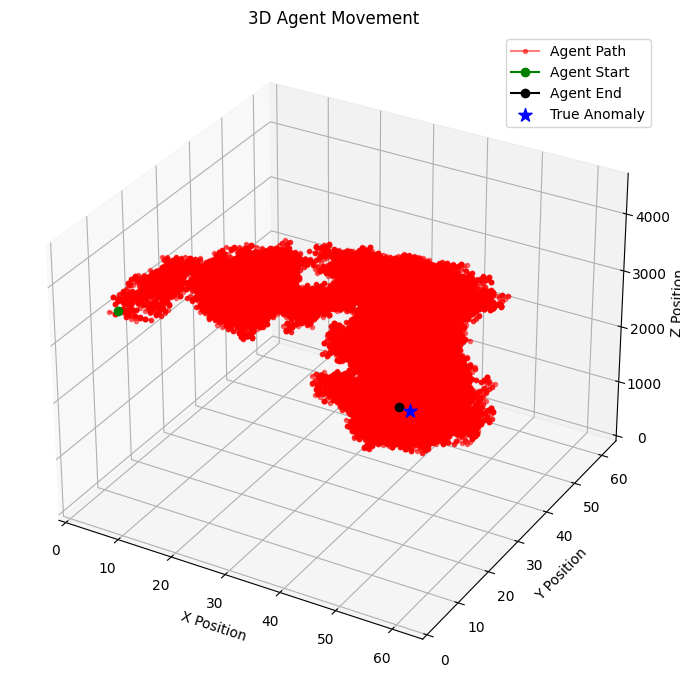

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

positions = np.array(positions)
x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]

# Define cube boundaries
x_min, x_max = 0, chunk.shape[1]
y_min, y_max = 0, chunk.shape[2]
z_min, z_max = 0, chunk.shape[0]

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot agent movement
ax.plot(x, y, z, color='red', marker='.', alpha=0.5, label='Agent Path')
ax.plot(x[0], y[0], z[0], color='green', marker='o', label='Agent Start')
ax.plot(x[-1], y[-1], z[-1], color='black', marker='o', label='Agent End')

# Mark true anomaly (assuming first position is the anomaly)
ax.scatter(40, 40, 1000, color='blue', s=100, marker='*', label='True Anomaly')

# Set labels
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_zlabel("Z Position")
ax.set_title("3D Agent Movement")

# Set boundaries
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])

ax.legend()
plt.tight_layout()
plt.show()

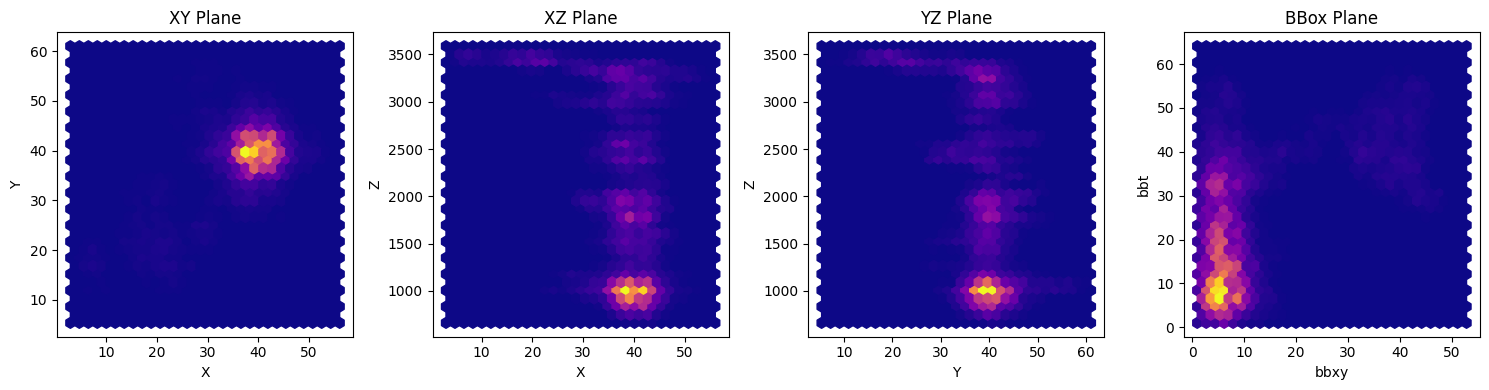

In [42]:
x, y, z, bbxy, bbt = np.array(positions).T  # Unpack x, y, z coordinates

# Define a function to plot 2D histograms
def plot_2d_hist(ax, x_data, y_data, xlabel, ylabel, cmap="plasma"):
    # Create a 2D histogram
    hb = ax.hexbin(x_data, y_data, gridsize=30, cmap=cmap)
    
    # Add labels and colorbar
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return hb

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

# XY plane 2D histogram
hb1 = plot_2d_hist(axes[0], x, y, "X", "Y")
axes[0].set_title("XY Plane")

# XZ plane 2D histogram
hb2 = plot_2d_hist(axes[1], x, z, "X", "Z")
axes[1].set_title("XZ Plane")

# YZ plane 2D histogram
hb3 = plot_2d_hist(axes[2], y, z, "Y", "Z")
axes[2].set_title("YZ Plane")

# bounding box plane 2D histogram
hb3 = plot_2d_hist(axes[3], bbxy, bbt, "bbxy", "bbt")
axes[3].set_title("BBox Plane")

plt.tight_layout()
plt.show()

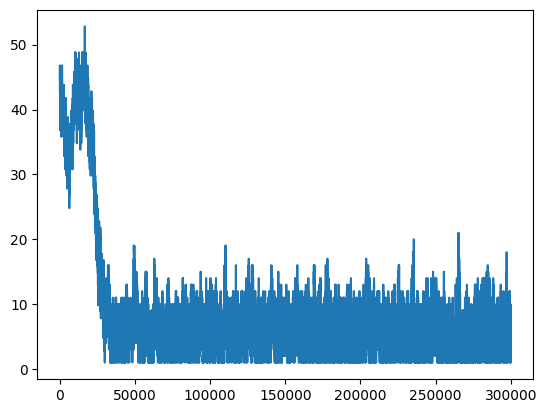

In [53]:
plt.figure()
plt.plot(bbxy)

In [50]:
def count_near_positions(positions, a_x, a_y, a_t):
    x, y, t = positions[:, 0], positions[:, 1], positions[:, 2]
    
    condition = (np.abs(x - a_x) < 5) & (np.abs(y - a_y) < 5) & (np.abs(t - a_t) < 100)
    
    return np.sum(condition)

In [51]:
# Example usage:
a_x, a_y, a_t = 40, 40, 1000
count = count_near_positions(positions, a_x, a_y, a_t)
print(count)

58645


In [52]:
58645 / positions.shape[0]

0.19548333333333334